In [1]:
%cd /DATA/glacier-vel/output/2017/2017_dem

/DATA/glacier-vel/output/2017/2017_dem


In [2]:
ls 

DemApps.py                                  DemProc.xml
demh.npy                                    fine_coreg/
demLat_N31_N34_Lon_E076_E079.dem            fine_interferogram/
demLat_N31_N34_Lon_E076_E079.dem.vrt        fine_offsets/
demLat_N31_N34_Lon_E076_E079.dem.wgs84      geom_reference/
demLat_N31_N34_Lon_E076_E079.dem.wgs84.vrt  isce.log
demLat_N31_N34_Lon_E076_E079.dem.wgs84.xml  merged/
demLat_N31_N34_Lon_E076_E079.dem.xml        PICKLE/
demLat_zero.tif                             reference/
demLat_zero.tif.vrt                         reference.xml
demLat_zero.tif.wgs84                       secondary/
demLat_zero.tif.wgs84.vrt                   secondary.xml
demLat_zero.tif.wgs84.xml                   topsApp.xml
demLat_zero.tif.xml                         topsinsar.log


In [2]:
import isce
import isceobj
import numpy as np
from isceobj.Util.ImageUtil import ImageLib as IML
from isceobj.Planet.Planet import Planet

def loadProduct(xmlname):
    '''
    Load the product using Product Manager.
    '''

    from iscesys.Component.ProductManager import ProductManager as PM

    pm = PM()
    pm.configure()

    obj = pm.loadProduct(xmlname)

    return obj

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


In [4]:
from DemApps import *

In [5]:
insar = DemInSAR(name="DemApp", cmdline='topsApp.xml')
insar.configure()
# insar.run()

2023-01-14 01:22:34,348 - isce.insar - INFO - ISCE VERSION = 2.5.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20210823, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.5.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20210823, CURRENT_SVN_REVISION = 

2023-01-14 01:22:34,367 - isce.insar - WARNING - Some filenames in insarApp.geocode_list configuration are different from those in InsarProc. Using names given to insarApp.
insarApp.geocode_list = ['merged/phsig.cor', 'merged/filt_topophase.unw', 'merged/range.rdr', 'merged/look_angle.rdr', 'merged/bp.rdr', 'merged/bn.rdr', 'merged/los.rdr', 'merged/z.rdr', 'merged/incid.rdr', 'merged/topophase.flat', 'merged/filt_topophase.flat', 'merged/topophase.cor', 'merged/filt_topophase.unw.conncomp']
InsarProc.geocode_list = ['merged/phsig.cor', 'merged/topophase.cor', 'merged/filt_topophase.unw', 'merged/los.rdr', 'merged/topophase.flat', 'merged/filt_topophase.flat', 'merged/filt_topophase_2stage.unw']


In [5]:
img  = isceobj.createImage()
img.load( './merged/filt_topophase.unw.xml')
bands = img.bands 
dtype = img.dataType
# img.filename = outfile

In [7]:
def get_earthRadius(posZ, height, ellip):
    re = ellip.a
    rp = ellip.b
    lat = np.arcsin(posZ/height)
    return (re*rp)/np.sqrt((rp*np.cos(lat))**2 + (re*np.sin(lat))**2)

In [8]:
import datetime

los = IML.mmapFromISCE('./merged/los_dem.rdr').bands[0]  
unw = IML.mmapFromISCE('./merged/filt_topophase.unw').bands[1]
h_zero = IML.mmapFromISCE('./merged/hgt_zero.rdr').bands[0]
h_dem = IML.mmapFromISCE('./merged/hgt.rdr').bands[0]
H = h_zero.copy()
rnglook = 19
azlook = 7
swath_width = los.shape[1]*19/2
swath_height = los.shape[1]*7/6
wavelength = 0.056
deg2rad = np.pi/180
thresh = 0.05

mllines, mlpixel = los.shape

for i in range(10):
    print('Change to line no.', i)
    line = azlook*i + (azlook//2)
    curheight = 0
    lastheight = 0
    Bperp = 0
    Bpar = 0
    nburst = int(line//swath_height)
    tmpphase = 0
    tmppixel = 0
#     swath = tmppixel//swath_width
    
    if (unw[i,:]!=0).sum()!=0:
        lineok = True
    else:
        lineok = False
        continue
    
    mid = mlpixel//2
    if lineok:
        for j in range(mid+1):
#             print(j)
            if unw[i, mid-j]!=0:
                tmpphase = unw[i, mid-j]
                tmpj = mid-j
                tmppixel = rnglook*(mid-j) + (rnglook//2)
                break
            if unw[i, mid+j]!=0:
                tmpphase = unw[i, mid+j]
                tmppixel = rnglook*(mid+j) + (rnglook//2)
                break
            
    # Iterating for Baseline
    swath = tmppixel//swath_width + 1
    reference = loadProduct('./reference/IW{0}.xml'.format(int(swath)))
    secondary = loadProduct('./secondary/IW{0}.xml'.format(int(swath)))
    
    mBurst = reference.bursts[nburst]
    sBurst = secondary.bursts[nburst]
#     tmid = mBurst.sensingMid
#     referenceSV = reference.orbit.interpolate(tmid, method='hermite')
#     secondarySV = secondary.orbit.interpolate(tmid, method='hermite')
    
    strt_rng = mBurst.startingRange
    pixelsize = mBurst.rangePixelSize
    
    deltaT = datetime.timedelta(seconds=(line - 1)*mBurst.azimuthTimeInterval)
    tline = mBurst.sensingStart + deltaT
    referenceSV = mBurst.orbit.interpolate(tline, method='hermite')
    temprng = strt_rng + pixelsize*tmppixel
    
    refElp = Planet(pname='Earth').ellipsoid
#     ELIP = Planet(pname='Earth').ellipsoid
    inc_angle = los[i, tmpj]
    tempphase = unw[i, tmpj]
    
    for j in range(4):
        target = mBurst.orbit.rdr2geo(tline, temprng, height=curheight) 
        slvTime, slvrng = sBurst.orbit.geo2rdr(target)
        secondarySV = sBurst.orbit.interpolateOrbit(slvTime, method='hermite')

        targxyz = np.array(refElp.LLH(target[0], target[1], target[2]).ecef().tolist())
        mxyz = np.array(referenceSV.getPosition())
        mvel = np.array(referenceSV.getVelocity())
        sxyz = np.array(secondarySV.getPosition())
        mvelunit = mvel / np.linalg.norm(mvel)
        sxyz = sxyz - np.dot ( sxyz-mxyz, mvelunit) * mvelunit

        aa = np.linalg.norm(sxyz-mxyz)
        costheta = (temprng*temprng + aa*aa - slvrng*slvrng)/(2.*temprng*aa)
        perp = aa * np.sqrt(1 - costheta*costheta)
        direction = np.sign(np.dot( np.cross(targxyz-mxyz, sxyz-mxyz), mvel))
        Bpar = aa*costheta
        sintheta = np.sqrt(1-(costheta**2))
        Bperp = direction*perp
        
        lastheight = curheight
        curheight = (-wavelength*temprng*np.sin(inc_angle*deg2rad)*tempphase)/(4*np.pi*Bperp)
#         print(Bperp, Bpar, tempphase, curheight, costheta, slvTime)
        
        if np.abs(lastheight-curheight) < thresh:
            break
        
    Bhor = Bperp*costheta + Bpar*sintheta
    Bver = Bperp*costheta - Bpar*sintheta
    curheight = 0
    lastheight = 0
    for j in range(50):
        if unw[i, j]==0:
            continue
        
        
        pixel = rnglook*j + (rnglook//2)
        rng = strt_rng + pixelsize*pixel
#         inc_angle = 
        
        target = mBurst.orbit.rdr2geo(tline, rng, height=curheight) 
        targxyz = np.array(refElp.LLH(target[0], target[1], target[2]).ecef().tolist())
        slvTime, slvrng = sBurst.orbit.geo2rdr(target)
        secondarySV = sBurst.orbit.interpolateOrbit(slvTime, method='hermite')
        mxyz = np.array(referenceSV.getPosition())
        print("!!!", np.linalg.norm(targxyz-mxyz), rng)
        mvel = np.array(referenceSV.getVelocity())
        sxyz = np.array(secondarySV.getPosition())
        mvelunit = mvel / np.linalg.norm(mvel)
        sxyz = sxyz - np.dot ( sxyz-mxyz, mvelunit) * mvelunit
        print(mxyz)
        aa = np.linalg.norm(sxyz-mxyz)
        
        denominator = 2*aa*rng
        numerator = rng*rng + aa*aa
#         print(unw[i,j], los[i,j])
        phase = unw[i,j]
        
        for j in range(4):
            
            target = mBurst.orbit.rdr2geo(tline, rng, height=curheight) 
            slvTime, slvrng = sBurst.orbit.geo2rdr(target)
            secondarySV = sBurst.orbit.interpolateOrbit(slvTime, method='hermite')
            targxyz = np.array(refElp.LLH(target[0], target[1], target[2]).ecef().tolist())
            
            costheta = (numerator - slvrng*slvrng)/denominator
            sintheta = np.sqrt(1-(costheta**2))
            ht = np.linalg.norm(mxyz)
            er = get_earthRadius(mxyz[2], ht, refElp)
            cosla = ((rng**2 + ht**2 - er**2)/(2*ht*rng))
            print(los[i,j], np.arccos(cosla)*180/np.pi)
            lastheight = curheight
            curheight = (-wavelength*rng*np.sin(los[i,j]*deg2rad)*phase)/(4*np.pi*(Bhor*costheta + Bver*sintheta))
            
            
            if np.abs(lastheight-curheight) < thresh:
                H[i,j] = curheight
#                 print(curheight, phase, los[i,j])
                break
        
                

Change to line no. 0
Change to line no. 1
Change to line no. 2
Change to line no. 3
!!! 800071.370391282 800071.3703912823
[1744947.24821687 5807964.65982781 3637844.76560829]
31.002522 27.43732189602955
31.006372 27.43732189602955
!!! 800115.632071462 800115.6320714619
[1744947.24821687 5807964.65982781 3637844.76560829]
31.002522 27.442648127690628
31.006372 27.442648127690628
31.008747 27.442648127690628
!!! 800159.8937516407 800159.8937516415
[1744947.24821687 5807964.65982781 3637844.76560829]
31.002522 27.447972773932527
31.006372 27.447972773932527
!!! 800204.1554318207 800204.155431821
[1744947.24821687 5807964.65982781 3637844.76560829]
31.002522 27.45329583575697
31.006372 27.45329583575697
!!! 800248.4171120008 800248.4171120006
[1744947.24821687 5807964.65982781 3637844.76560829]
31.002522 27.458617314164407
31.006372 27.458617314164407
!!! 800292.6787921803 800292.6787921803
[1744947.24821687 5807964.65982781 3637844.76560829]
31.002522 27.463937210154604
31.006372 27.4639

Exception: Interpolation time out of bounds

In [12]:
np.linalg.norm(mxyz-targxyz)

801310.6974363105

In [21]:
np.linalg.norm(mxyz)

7071860.358316759

In [53]:
refElp = Planet(pname='Earth').ellipsoid
refElp.a += 10000000
refElp.b

16323224.207598044

In [7]:
np.arccos(0.5)*180/np.pi

60.00000000000001

In [37]:
import datetime

deltaT = datetime.timedelta(seconds=(line - 1)*mBurst.azimuthTimeInterval)
tt = mBurst.sensingStart + deltaT
tt

datetimeType(2017, 9, 16, 12, 47, 57, 959802)

In [26]:
swath = 2
'./reference/IW{0}.xml'.format(swath)

'./reference/IW2.xml'

In [36]:
line

31

In [44]:
ref = loadProduct('./reference/IW2.xml')
# sec = loadProduct('./secondary/IW1.xml')
print(ref.bursts[2].sensingMid, ref.bursts[0].sensingMid)

2017-09-16 12:48:11.424723 2017-09-16 12:48:05.905555


In [47]:
ref.bursts[0]

In [18]:
import numpy as np

ref = loadProduct('./reference/IW2.xml')
tmid = ref.sensingMid
referenceSV = ref.orbit.interpolate(tmid, method='hermite')
rng = ref.midRange
target = ref.orbit.rdr2geo(tmid, rng)
target[2] = 5000
slvTime, slvrng = sec.orbit.geo2rdr(target)
# secondarySV = sec.orbit.interpolateOrbit(slvTime, method='hermite')


print(target)
targxyz = np.array(refElp.LLH(target[0], target[1], target[2]).ecef().tolist())
# print(ref.bursts[2].sensingMid, ref.bursts[0].sensingMid)

[32.66395745660681, 78.30269310191913, 5000]


In [60]:
# rng = ref.startingRange
tmid

datetimeType(2017, 9, 16, 12, 48, 8, 665139)

In [49]:
slvrng

871783.8259428616

In [42]:
targxyz

array([1089669.52302492, 5263060.88296055, 3422644.04825351])

2023-01-13 15:55:28,940 - matplotlib.colorbar - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f04a93be940>
2023-01-13 15:55:28,941 - matplotlib.colorbar - DEBUG - Using auto colorbar locator on colorbar
2023-01-13 15:55:28,942 - matplotlib.colorbar - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f04a93be940>
2023-01-13 15:55:28,942 - matplotlib.colorbar - DEBUG - Setting pcolormesh


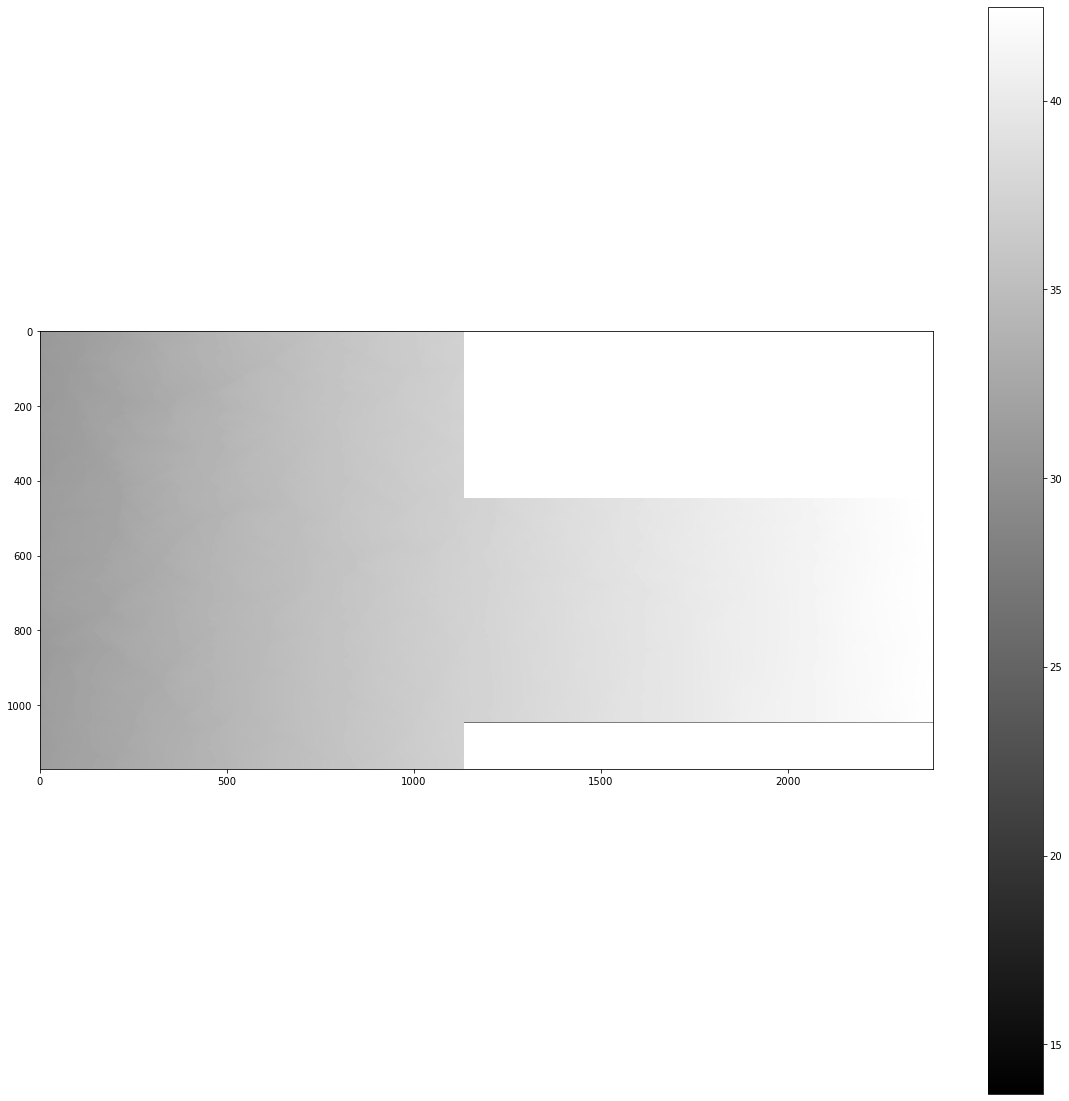

In [25]:
import matplotlib.pyplot as plt
Los = los.copy()
Los[los==0] = np.nan
fig = plt.figure(figsize=(20,20))
ax = plt.imshow(Los, cmap='gray')
fig.colorbar(ax)
plt.show()

In [ ]:
unw.shape